In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC

# Sampling : BoGender

In [ ]:
df = pd.read_csv('../Data/Cleaned_data.csv')
print(df['BoGender'].value_counts())

# df = df[df['BoGender'] != 3]
min_count = df['BoGender'].value_counts().min()
df = df.groupby('BoGender').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
print(df['BoGender'].value_counts())

BoGender
1    489015
2    166485
3     25367
Name: count, dtype: int64

# train_test_split


Training/Testing Split: 70%/30%

Model: ZeroR
 Accuracy: 0.3291, Precision: 0.7764, Recall: 0.3333, F1-Score: 0.1651, Specificity: 0.6667
Time taken: 0.04 seconds

Model: Random Forest
 Accuracy: 0.7342, Precision: 0.7384, Recall: 0.7337, F1-Score: 0.7357, Specificity: 0.8673
Time taken: 21.80 seconds

Model: Decision Tree
 Accuracy: 0.6408, Precision: 0.6398, Recall: 0.6401, F1-Score: 0.6399, Specificity: 0.8206
Time taken: 1.60 seconds

Model: Extra Trees
 Accuracy: 0.7275, Precision: 0.7310, Recall: 0.7269, F1-Score: 0.7287, Specificity: 0.8640
Time taken: 9.44 seconds

Model: Gradient Boosting
 Accuracy: 0.7397, Precision: 0.7437, Recall: 0.7391, F1-Score: 0.7411, Specificity: 0.8700
Time taken: 67.92 seconds



d:\DataScience\CIS890\venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

d:\DataScience\CIS890\venv\lib\site-packages\xgboost\training.py:183: UserWarning:

[14:23:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Model: Logistic Regression
 Accuracy: 0.4540, Precision: 0.4549, Recall: 0.4538, F1-Score: 0.4530, Specificity: 0.7270
Time taken: 11.50 seconds

Model: XGBoost
 Accuracy: 0.7511, Precision: 0.7542, Recall: 0.7504, F1-Score: 0.7520, Specificity: 0.8757
Time taken: 2.24 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3436
[LightGBM] [Info] Number of data points in the train set: 53270, number of used features: 28
[LightGBM] [Info] Start training from score -1.093146
[LightGBM] [Info] Start training from score -1.100736
[LightGBM] [Info] Start training from score -1.101978
Model: LightGBM
 Accuracy: 0.7548, Precision: 0.7579, Recall: 0.7541, F1-Score: 0.7555, Specificity: 0.8775
Time taken: 1.98 seconds

Model: CatBoost
 Accuracy: 0.7543, Precision: 0.7579, Re

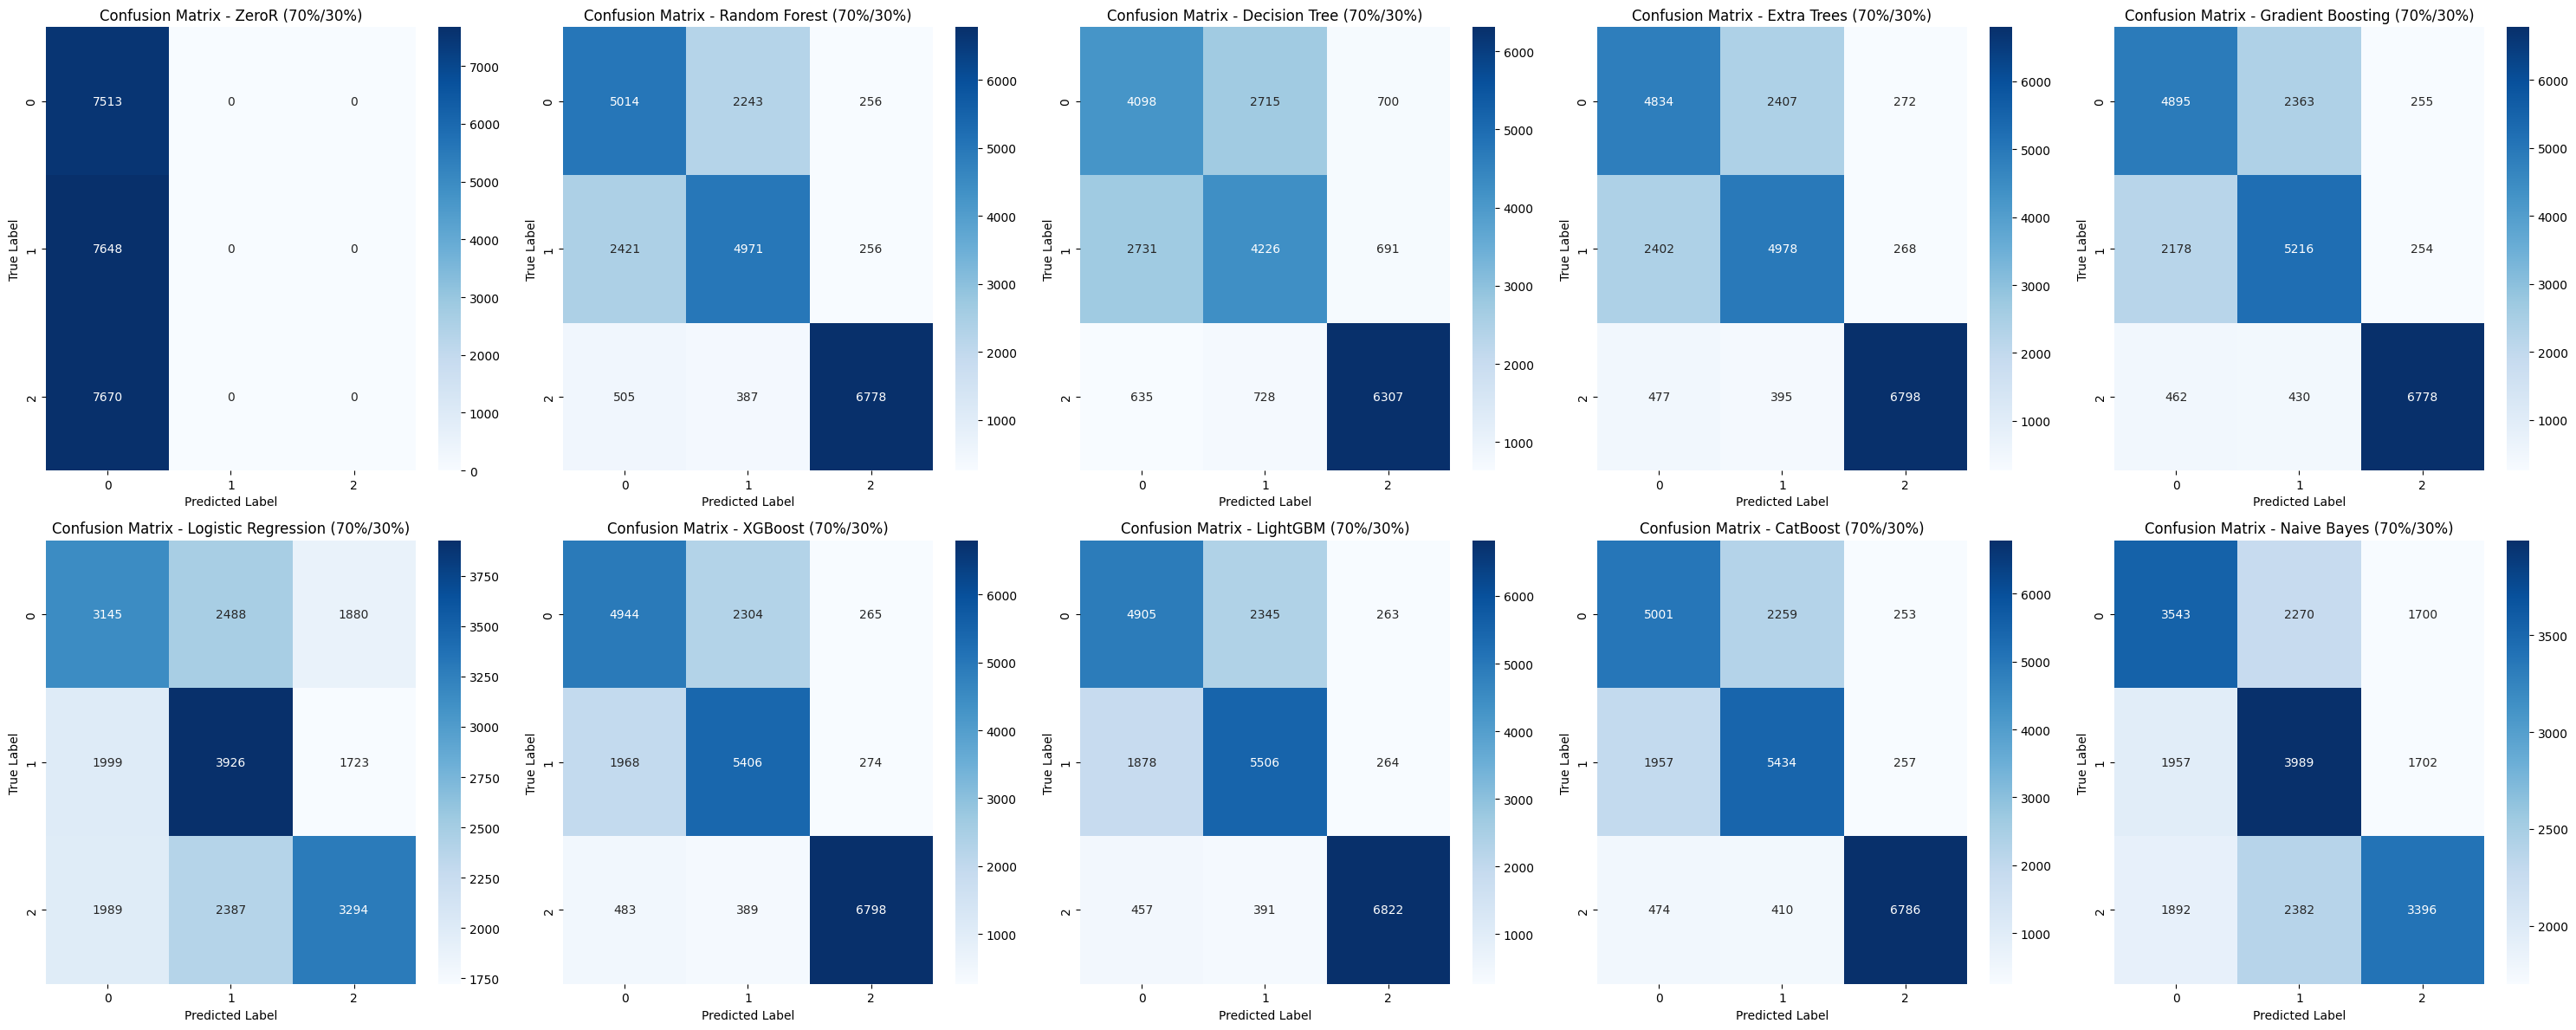

In [ ]:
results_dir = "BoGender_SPLITS"
os.makedirs(results_dir, exist_ok=True)

X = df.drop(columns=["BoGender", "CoGender"])
y = df["BoGender"]

# splits = [(0.90, 0.10), (0.80, 0.20), (0.70, 0.30)]
train_size = 0.70
test_size = 0.30

models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    # "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42), 
    # "KNN": KNeighborsClassifier(n_neighbors=3),
    models["Logistic Regression"] = LogisticRegression(max_iter=1000, random_state=42)
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    models["LightGBM"] = LGBMClassifier(random_state=42)
    models["CatBoost"] = CatBoostClassifier(verbose=0, random_state=42)
    models["Naive Bayes"] = GaussianNB()
    # models["SVM"] = SVC(probability=True, random_state=42)
}


def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)  # True Negatives per class
    fp = np.sum(cm, axis=0) - np.diag(cm)  # False Positives per class
    specificity_per_class = tn / (tn + fp)  # Compute specificity per class
    return np.mean(specificity_per_class)  # Return the average specificity

train_percent = int(train_size * 100)
test_percent = int(test_size * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(f"\nTraining/Testing Split: {train_percent}%/{test_percent}%\n")

results = {}
conf_matrices = {}
for name, model in models.items():
    start_time = time.time()
    
    if name == "XGBoost":
        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)
        model.fit(X_train, y_train_enc)
        y_pred = le.inverse_transform(model.predict(X_test))

    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=1)
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    spec = specificity_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    elapsed_time = time.time() - start_time
    
    results[name] = {
        "Accuracy": acc, 
        "Precision": prec, 
        "Recall": rec, 
        "F1-Score": f1, 
        "Specificity": spec,
        "Total Runtime (s)": elapsed_time,
    }
    conf_matrices[name] = cm
    print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
    print("Time taken: {:.2f} seconds\n".format(elapsed_time))
    
results_df = pd.DataFrame(results).T
results_file = f"{results_dir}/results_split_{train_percent}_{test_percent}.csv"
results_df.to_csv(results_file, index=True)
print(f"Results saved to {results_file}")

for name, cm in conf_matrices.items():
    cm_file = f"{results_dir}/conf_matrix_{train_percent}_{test_percent}_{name.replace(' ', '_')}.csv"
    pd.DataFrame(cm).to_csv(cm_file, index=False)
    print(f"Confusion Matrix for {name} saved to {cm_file}")

fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [4]:
from interpret.glassbox import ExplainableBoostingClassifier
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)
from interpret import show
ebm_global = ebm.explain_global()
show(ebm_global)

d:\DataScience\CIS890\venv\lib\site-packages\interpret\glassbox\_ebm\_ebm.py:1165: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


<!-- http://127.0.0.1:7001/2244631587584/ -->

# cross_val_predict

In [ ]:
cv_results_dir = "BoGender_CV"
os.makedirs(cv_results_dir, exist_ok=True)

X = df.drop(columns=["BoGender", "CoGender"])
y = df["BoGender"]

folds_list = [5]
num_folds = 5

models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    # "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42), 
    # "KNN": KNeighborsClassifier(n_neighbors=3),
    models["Logistic Regression"] = LogisticRegression(max_iter=1000, random_state=42)
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    models["LightGBM"] = LGBMClassifier(random_state=42)
    models["CatBoost"] = CatBoostClassifier(verbose=0, random_state=42)
    models["Naive Bayes"] = GaussianNB()
    # models["SVM"] = SVC(probability=True, random_state=42)
}

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)  # True Negatives per class
    fp = np.sum(cm, axis=0) - np.diag(cm)  # False Positives per class
    specificity_per_class = tn / (tn + fp)  # Compute specificity per class
    return np.mean(specificity_per_class)  # Return the average specificity

# for num_folds in folds_list:
print(f"\nPerforming {num_folds}-fold cross-validation\n")
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

results = {}
conf_matrices = {}

for name, model in models.items():
    start_time = time.time()
    y_pred = cross_val_predict(model, X, y, cv=kf)
    total_runtime = time.time() - start_time
    
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=1)
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    spec = specificity_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
    results[name] = {
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1,
        "Specificity": spec, "Total Runtime (s)": total_runtime, "Total Runtime (min)": total_runtime / 60
    }
    
    conf_matrices[name] = cm
    
    print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
    print("Time taken: {:.2f} seconds".format(total_runtime))
    print("Time taken: {:.2f} minutes\n".format(total_runtime / 60))

results_df = pd.DataFrame(results).T
results_file = f"{cv_results_dir}/results_cv_{num_folds}_folds.csv"
results_df.to_csv(results_file, index=True)
print(f"Results saved to {results_file}")

for name, cm in conf_matrices.items():
    cm_file = f"{cv_results_dir}/conf_matrix_cv_{num_folds}_folds_{name.replace(' ', '_')}.csv"
    pd.DataFrame(cm).to_csv(cm_file, index=False)
    print(f"Confusion Matrix for {name} saved to {cm_file}")

fig, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.ravel()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name} ({num_folds}-Folds CV)')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()
